In [17]:
# Observation data source from FMI (https://en.ilmatieteenlaitos.fi/download-observations)
import pandas as pd
# Daily observations for Espoo cirt
weather = pd.read_csv("espoo.csv", index_col="DATE")

In [18]:

weather

,STATION,PRCP,SNWD,TAVG,TMAX,TMIN
DATE,,,,,,
2013-11-26,Espoo,1.5,0,-2.0,2.7,-6.4
2013-11-27,Espoo,-1.0,0,4.7,5.8,2.7
2013-11-28,Espoo,-1.0,0,4.0,7.0,1.6
2013-11-29,Espoo,-1.0,0,-1.9,2.7,-5.2
2013-11-30,Espoo,1.0,0,-3.2,2.4,-9.2
...,...,...,...,...,...,...
2024-3-11,Espoo,-1.0,31,-2.0,3.1,-6.5
2024-3-12,Espoo,-1.0,31,-2.1,3.6,-6.8
2024-3-13,Espoo,0.7,32,-1.0,1.9,-6.9


In [19]:
# Get the percentage of the null values
null_pct = weather.apply(pd.isnull).sum()/weather.shape[0]
null_pct

STATION    0.0
PRCP       0.0
SNWD       0.0
TAVG       0.0
TMAX       0.0
TMIN       0.0
dtype: float64

In [20]:
# Get the columns that have less than 5% null values
valid_columns = weather.columns[null_pct < .05]
valid_columns

Index(['STATION', 'PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN'], dtype='object')

In [21]:
weather = weather[valid_columns].copy()
weather.columns = weather.columns.str.lower()

In [22]:
weather

,station,prcp,snwd,tavg,tmax,tmin
DATE,,,,,,
2013-11-26,Espoo,1.5,0,-2.0,2.7,-6.4
2013-11-27,Espoo,-1.0,0,4.7,5.8,2.7
2013-11-28,Espoo,-1.0,0,4.0,7.0,1.6
2013-11-29,Espoo,-1.0,0,-1.9,2.7,-5.2
2013-11-30,Espoo,1.0,0,-3.2,2.4,-9.2
...,...,...,...,...,...,...
2024-3-11,Espoo,-1.0,31,-2.0,3.1,-6.5
2024-3-12,Espoo,-1.0,31,-2.1,3.6,-6.8
2024-3-13,Espoo,0.7,32,-1.0,1.9,-6.9


In [23]:
weather = weather.ffill()
weather.apply(lambda x: (x == 9999).sum())

station    0
prcp       0
snwd       0
tavg       0
tmax       0
tmin       0
dtype: int64

In [24]:
weather.index

Index(['2013-11-26', '2013-11-27', '2013-11-28', '2013-11-29', '2013-11-30',
       '2013-12-1', '2013-12-2', '2013-12-3', '2013-12-4', '2013-12-5',
       ...
       '2024-3-6', '2024-3-7', '2024-3-8', '2024-3-9', '2024-3-10',
       '2024-3-11', '2024-3-12', '2024-3-13', '2024-3-14', '2024-3-15'],
      dtype='object', name='DATE', length=3763)

In [25]:
weather.index = pd.to_datetime(weather.index)
weather.index.year.value_counts().sort_index()

DATE
2013     36
2014    365
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    365
2023    365
2024     75
Name: count, dtype: int64

<Axes: xlabel='DATE'>

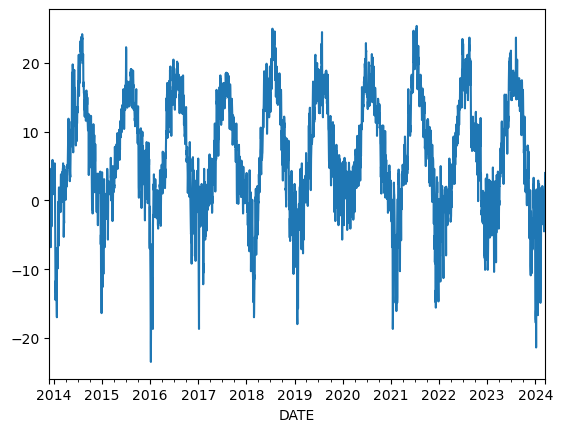

In [26]:
# plot average temperature for exercise
weather["tavg"].plot()

In [27]:
weather["target"] = weather.shift(-1)["tavg"]
weather = weather.ffill()

In [28]:
weather

,station,prcp,snwd,tavg,tmax,tmin,target
DATE,,,,,,,
2013-11-26,Espoo,1.5,0,-2.0,2.7,-6.4,4.7
2013-11-27,Espoo,-1.0,0,4.7,5.8,2.7,4.0
2013-11-28,Espoo,-1.0,0,4.0,7.0,1.6,-1.9
2013-11-29,Espoo,-1.0,0,-1.9,2.7,-5.2,-3.2
2013-11-30,Espoo,1.0,0,-3.2,2.4,-9.2,1.8
...,...,...,...,...,...,...,...
2024-03-11,Espoo,-1.0,31,-2.0,3.1,-6.5,-2.1
2024-03-12,Espoo,-1.0,31,-2.1,3.6,-6.8,-1.0
2024-03-13,Espoo,0.7,32,-1.0,1.9,-6.9,3.0


In [29]:
from sklearn.linear_model import Ridge

rr = Ridge(alpha=.1)

In [30]:
predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]
predictors

Index(['prcp', 'snwd', 'tavg', 'tmax', 'tmin'], dtype='object')

In [31]:
def backtest(weather, model, predictors, start=3650, step=90):
    all_predictions = []
    
    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]
        
        model.fit(train[predictors], train["target"])
        
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [32]:
predictions = backtest(weather, rr, predictors)
predictions

,actual,prediction,diff
DATE,,,
2023-11-24,-9.5,-1.334263,8.165737
2023-11-25,-10.0,-8.959183,1.040817
2023-11-26,-10.9,-8.997316,1.902684
2023-11-27,-4.0,-9.859295,5.859295
2023-11-28,-1.6,-2.231255,0.631255
...,...,...,...
2024-03-11,-2.1,-1.762568,0.337432
2024-03-12,-1.0,-1.818018,0.818018
2024-03-13,3.0,-0.234559,3.234559


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_absolute_error(predictions["actual"], predictions["prediction"])

2.3103013591987343

In [34]:
predictions.sort_values("diff", ascending=False)

,actual,prediction,diff
DATE,,,
2024-01-07,-6.7,-20.342397,13.642397
2023-12-30,-13.8,-3.471119,10.328881
2024-01-20,-6.4,-16.149225,9.749225
2023-11-24,-9.5,-1.334263,8.165737
2024-01-19,-16.7,-9.055113,7.644887
...,...,...,...
2023-12-26,-3.4,-3.265083,0.134917
2024-02-03,0.5,0.633061,0.133061
2024-02-24,1.5,1.417864,0.082136


In [35]:
pd.Series(rr.coef_, index=predictors)

prcp    0.032280
snwd   -0.022057
tavg    1.302981
tmax   -0.049506
tmin   -0.332003
dtype: float64

In [36]:
def pct_diff(old, new):
    return (new - old) / old

def compute_rolling(weather, horizon, col):
    label = f"rolling_{horizon}_{col}"
    weather[label] = weather[col].rolling(horizon).mean()
    weather[f"{label}_pct"] = pct_diff(weather[label], weather[col])
    return weather
    
rolling_horizons = [10, 20]
for horizon in rolling_horizons:
    for col in ["tmax", "tmin", "prcp"]:
        weather = compute_rolling(weather, horizon, col)

In [37]:
def expand_mean(df):
    return df.expanding(1).mean()

for col in ["tmax", "tmin", "prcp"]:
    weather[f"month_avg_{col}"] = weather[col].groupby(weather.index.month, group_keys=False).apply(expand_mean)
    weather[f"day_avg_{col}"] = weather[col].groupby(weather.index.day_of_year, group_keys=False).apply(expand_mean)

In [38]:
weather = weather.iloc[20:,:]
weather

,station,prcp,snwd,tavg,tmax,tmin,target,rolling_10_tmax,rolling_10_tmax_pct,rolling_10_tmin,...,rolling_20_tmin,rolling_20_tmin_pct,rolling_20_prcp,rolling_20_prcp_pct,month_avg_tmax,day_avg_tmax,month_avg_tmin,day_avg_tmin,month_avg_prcp,day_avg_prcp
DATE,,,,,,,,,,,,,,,,,,,,,
2013-12-16,Espoo,1.7,0,4.6,5.3,2.8,4.7,2.31,1.294372,-3.02,...,-2.710,-2.033210,0.445,2.820225,2.850000,5.300000,-2.756250,2.800000,0.681250,1.700000
2013-12-17,Espoo,-1.0,0,4.7,7.4,2.9,1.7,2.96,1.500000,-2.53,...,-2.700,-2.074074,0.445,-3.247191,3.117647,7.400000,-2.423529,2.900000,0.582353,-1.000000
2013-12-18,Espoo,-1.0,0,1.7,3.2,0.0,2.4,3.48,-0.080460,-2.07,...,-2.780,-1.000000,0.445,-3.247191,3.122222,3.200000,-2.288889,0.000000,0.494444,-1.000000
2013-12-19,Espoo,3.6,0,2.4,3.1,1.6,3.5,4.19,-0.260143,-1.05,...,-2.440,-1.655738,0.675,4.333333,3.121053,3.100000,-2.084211,1.600000,0.657895,3.600000
2013-12-20,Espoo,1.6,0,3.5,5.3,1.6,4.4,4.46,0.188341,0.23,...,-1.900,-1.842105,0.705,1.269504,3.230000,5.300000,-1.900000,1.600000,0.705000,1.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,Espoo,-1.0,31,-2.0,3.1,-6.5,-2.1,2.10,0.476190,-4.29,...,-2.375,1.736842,0.980,-2.020408,3.576947,3.036364,-3.013707,-3.645455,0.641745,0.790909
2024-03-12,Espoo,-1.0,31,-2.1,3.6,-6.8,-1.0,2.26,0.592920,-4.98,...,-2.670,1.546816,0.625,-2.600000,3.577019,4.790909,-3.025466,-3.827273,0.636646,2.672727
2024-03-13,Espoo,0.7,32,-1.0,1.9,-6.9,3.0,2.14,-0.112150,-5.66,...,-3.020,1.284768,0.615,0.138211,3.571827,4.236364,-3.037461,-2.327273,0.636842,2.018182


In [39]:
weather = weather.fillna(0)
weather.describe()

,prcp,snwd,tavg,tmax,tmin,target,rolling_10_tmax,rolling_10_tmax_pct,rolling_10_tmin,rolling_10_tmin_pct,...,rolling_20_tmin,rolling_20_tmin_pct,rolling_20_prcp,rolling_20_prcp_pct,month_avg_tmax,day_avg_tmax,month_avg_tmin,day_avg_tmin,month_avg_prcp,day_avg_prcp
count,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000,3.743000e+03,...,3743.000000,3.743000e+03,3743.000000,3.743000e+03,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000
mean,1.465830,3.790810,6.577505,10.068074,3.064894,6.577344,10.067411,-0.209719,3.064876,-4.251935e+12,...,3.065566,1.440651e+12,1.467740,-3.258683e+12,10.067693,10.076281,3.242809,3.233518,1.405429,1.432971
std,4.586091,10.341745,8.282451,9.135530,7.955392,8.282495,8.739010,12.263580,7.275137,2.327780e+14,...,7.042849,6.991920e+13,1.469236,1.993664e+14,8.019998,8.321286,6.319781,6.701097,0.747319,2.384173
min,-1.000000,-1.000000,-23.500000,-21.100000,-26.200000,-23.500000,-11.680000,-491.000000,-18.300000,-1.407375e+16,...,-17.250000,-1.281000e+03,-1.000000,-1.219725e+16,-4.600000,-13.900000,-8.683529,-19.700000,-1.000000,-1.000000
25%,-1.000000,-1.000000,0.900000,2.900000,-1.600000,0.900000,2.840000,-0.221333,-1.800000,-5.573306e-01,...,-2.015000,-6.879064e-01,0.370000,-1.677966e+00,3.431409,3.006250,-1.657217,-1.900000,0.792083,-0.064583
50%,-1.000000,-1.000000,5.800000,9.400000,2.500000,5.800000,9.230000,-0.011038,2.050000,-1.315789e-02,...,2.075000,-3.635567e-02,1.245000,-8.308668e-01,9.026744,8.700000,1.366667,2.066667,1.480882,0.875000
75%,1.900000,2.000000,13.700000,18.000000,9.500000,13.700000,18.160000,0.199265,9.575000,4.343456e-01,...,9.555000,4.439490e-01,2.355000,1.045692e+00,16.989403,18.061250,8.906675,9.358333,1.860496,2.252778
max,60.100000,56.000000,25.400000,32.800000,22.900000,25.400000,28.240000,449.000000,19.320000,8.314338e+14,...,18.115000,4.067767e+15,8.330000,2.590000e+02,26.828571,29.800000,16.814286,21.300000,4.711111,38.200000


In [40]:
predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]

In [41]:
predictions = backtest(weather, rr, predictors)

/Users/rehabaam/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.9715e-32): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/rehabaam/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.04678e-32): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [42]:
mean_squared_error(predictions["actual"], predictions["prediction"])

10.514838064065957

In [43]:
predictions.sort_values("diff", ascending=False)

,actual,prediction,diff
DATE,,,
2024-01-07,-6.7,-18.423673,11.723673
2023-12-30,-13.8,-3.473628,10.326372
2024-01-20,-6.4,-15.025978,8.625978
2024-01-19,-16.7,-8.971100,7.728900
2024-01-15,-16.0,-8.556676,7.443324
...,...,...,...
2023-12-21,0.9,1.102145,0.202145
2024-02-26,-0.3,-0.221609,0.078391
2024-02-03,0.5,0.464593,0.035407


In [44]:
weather.loc["2023-01-01": "2024-02-11"]

,station,prcp,snwd,tavg,tmax,tmin,target,rolling_10_tmax,rolling_10_tmax_pct,rolling_10_tmin,...,rolling_20_tmin,rolling_20_tmin_pct,rolling_20_prcp,rolling_20_prcp_pct,month_avg_tmax,day_avg_tmax,month_avg_tmin,day_avg_tmin,month_avg_prcp,day_avg_prcp
DATE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,Espoo,-1.0,8,0.4,5.6,-2.2,-1.9,1.84,2.043478,-4.52,...,-5.670,-0.611993,1.800,-1.555556,-0.900000,3.150000,-5.871786,-1.650000,1.659286,0.350000
2023-01-02,Espoo,9.7,8,-1.9,1.1,-4.3,-0.7,1.60,-0.312500,-4.89,...,-5.405,-0.204440,2.015,3.813896,-0.892883,1.390000,-5.866192,-2.930000,1.687900,2.770000
2023-01-03,Espoo,0.8,17,-0.7,1.5,-1.6,-3.9,1.78,-0.157303,-4.68,...,-4.745,-0.662803,1.975,-0.594937,-0.884397,-0.300000,-5.851064,-3.360000,1.684752,1.970000
2023-01-04,Espoo,-1.0,18,-3.9,-0.9,-7.5,-10.1,2.03,-1.443350,-4.39,...,-4.435,0.691094,1.975,-1.506329,-0.884452,0.290000,-5.856890,-5.610000,1.675265,0.570000
2023-01-05,Espoo,-1.0,17,-10.1,-7.1,-11.7,-9.7,1.52,-5.671053,-4.50,...,-4.180,1.799043,1.975,-1.506329,-0.906338,-2.710000,-5.877465,-7.450000,1.665845,1.460000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-07,Espoo,-1.0,35,-10.6,-5.5,-14.7,-14.8,1.08,-6.092593,-2.80,...,-5.070,1.899408,0.780,-2.282051,0.545329,-1.063636,-4.430450,-7.572727,1.537716,0.445455
2024-02-08,Espoo,-1.0,34,-14.8,-10.3,-19.4,-14.9,-0.31,32.225806,-4.90,...,-5.345,2.629560,0.780,-2.282051,0.507931,-0.436364,-4.482069,-5.427273,1.528966,1.027273
2024-02-09,Espoo,-1.0,35,-14.9,-10.0,-17.9,-13.1,-1.55,5.451613,-6.45,...,-5.225,2.425837,0.780,-2.282051,0.471821,-0.918182,-4.528179,-5.272727,1.520275,2.118182


<Axes: xlabel='diff'>

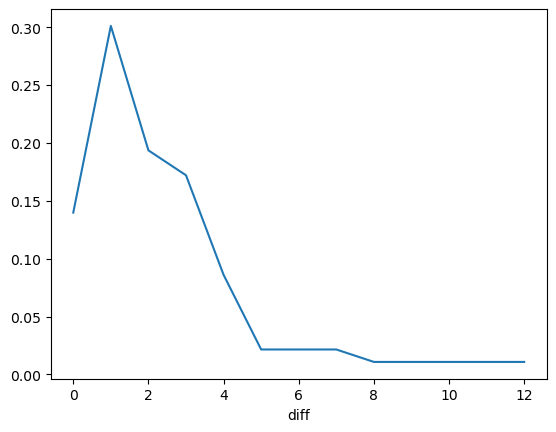

In [45]:
(predictions["diff"].round().value_counts().sort_index() / predictions.shape[0]).plot()

In [46]:
predictions

,actual,prediction,diff
DATE,,,
2023-12-14,-5.6,-4.871411,0.728589
2023-12-15,-0.7,-4.311733,3.611733
2023-12-16,2.3,0.391019,1.908981
2023-12-17,1.5,0.698314,0.801686
2023-12-18,3.3,0.232640,3.067360
...,...,...,...
2024-03-11,-2.1,-1.885107,0.214893
2024-03-12,-1.0,-2.034323,1.034323
2024-03-13,3.0,-0.005212,3.005212


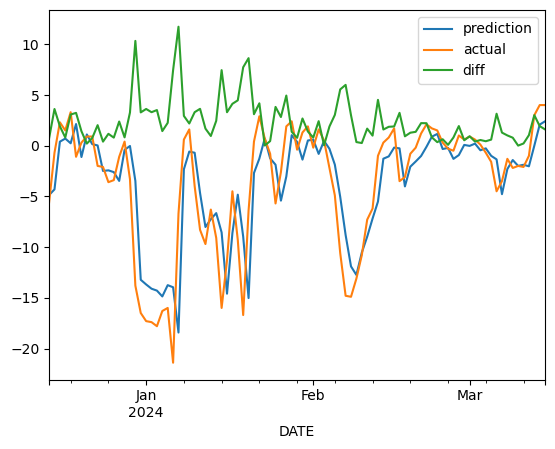

In [47]:
# plot average temperature for exercise
res = predictions["prediction"].plot(legend=True).get_figure()
res = predictions["actual"].plot(legend=True).get_figure()
res = predictions["diff"].plot(legend=True).get_figure()

# Save figure
res.savefig('weather.png')